In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from mdct import MDCT
from window import HanningWindow
from psychoac import SPL, Thresh

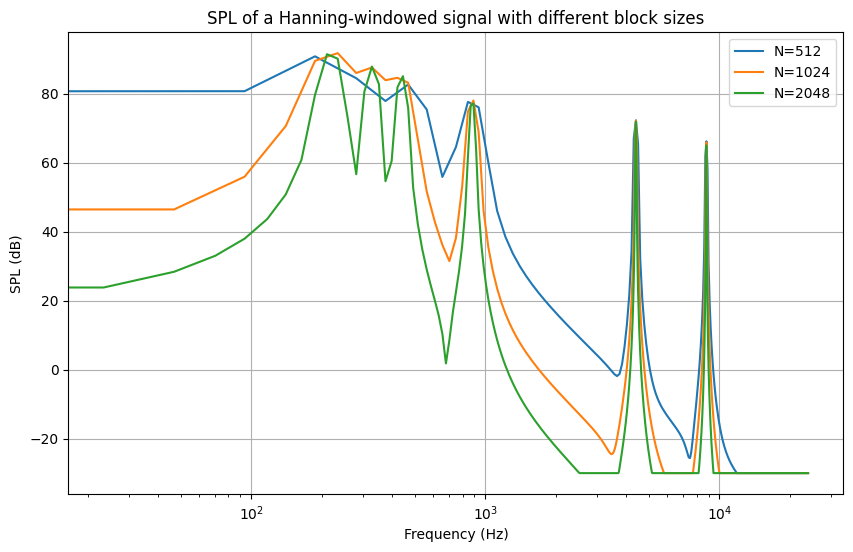

In [6]:
# 1.b)


def get_x(N, Fs):
    n_array = np.arange(N)
    x = (
        0.40 * np.cos(2 * np.pi * 220 * n_array / Fs)
        + 0.24 * np.cos(2 * np.pi * 330 * n_array / Fs)
        + 0.18 * np.cos(2 * np.pi * 440 * n_array / Fs)
        + 0.08 * np.cos(2 * np.pi * 880 * n_array / Fs)
        + 0.04 * np.cos(2 * np.pi * 4400 * n_array / Fs)
        + 0.02 * np.cos(2 * np.pi * 8800 * n_array / Fs)
    )
    return x


def get_intensity_from_DFT(X, gain_window=3 / 8):
    # get the intensity from a DFT result
    # window defaults to hanning window
    N = len(X)
    return 4.0 / (N * N * gain_window) * np.pow(np.abs(X), 2)


Ns = [512, 1024, 2048]
Fs = 48000
Xs = []
SPLs = []
for N in Ns:
    x = get_x(N, Fs)
    x_windowed = HanningWindow(x)
    X = scipy.fft.rfft(x_windowed)[:-1]
    Xs.append(X)
    spl = SPL(get_intensity_from_DFT(X))
    SPLs.append(spl)

plt.figure(figsize=(10, 6))
plt.title("SPL of a Hanning-windowed signal with different block sizes")
for N, spl in zip(Ns, SPLs):
    N_half = N // 2
    n_half_array = np.arange(N_half)
    freq_array = n_half_array / N * Fs

    plt.plot(freq_array, spl, label=f"N={N}")

plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")
# plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [7]:
from scipy.signal import find_peaks

for N, X, spl in zip(Ns, Xs, SPLs):
    peaks, peak_properties = find_peaks(spl, height=20)
    print(f"Detected {len(peaks)} peaks with N={N}")

    intensity = get_intensity_from_DFT(X)
    SPL_peaks = []
    freq_peaks = []
    for p in peaks:
        # aggregate the intensity values across the peak
        intensity_agg = intensity[p - 1] + intensity[p] + intensity[p + 1]
        SPL_peaks.append(SPL(intensity_agg))
        # center of mass interpolation for peak frequency estimation
        freq_peak = (
            Fs
            / N
            * (
                (p - 1) * intensity[p - 1]
                + p * intensity[p]
                + (p + 1) * intensity[p + 1]
            )
            / intensity_agg
        )
        freq_peaks.append(freq_peak)

    print(f"peak freqs:\t {np.around(freq_peaks, decimals=3)}")
    print(f"SPL of peaks:\t {np.around(SPL_peaks, decimals=3)}")

Detected 5 peaks with N=512
peak freqs:	 [ 196.967  459.899  878.499 4400.006 8800.055]
SPL of peaks:	 [92.067 84.475 80.045 74.061 68.038]
Detected 6 peaks with N=1024
peak freqs:	 [ 226.025  322.289  419.419  880.109 4400.028 8800.218]
SPL of peaks:	 [94.462 90.859 88.705 80.072 74.058 68.025]
Detected 6 peaks with N=2048
peak freqs:	 [ 219.681  330.034  440.079  880.517 4400.109 8799.435]
SPL of peaks:	 [94.02  89.618 87.114 80.016 74.046 67.969]


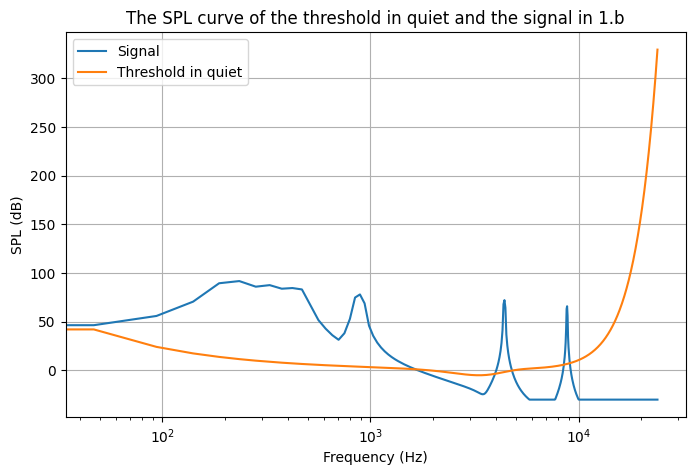

In [30]:
# 1.c)

N = 1024
spl = SPLs[1]
N_half = N // 2
n_half_array = np.arange(N_half)
freq_array = n_half_array / N * Fs
thresh = Thresh(freq_array)

plt.figure(figsize=(8, 5))
plt.title("The SPL curve of the threshold in quiet and the signal in 1.b")
plt.plot(freq_array, spl, label="Signal")
plt.plot(freq_array, thresh, label="Threshold in quiet")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")

plt.grid()
plt.legend()
plt.show()